<a href="https://colab.research.google.com/github/TasnimTamanna02/Store_Item_Demand_Forecasting/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm

In [ ]:
#Visualization Settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.style.use('ggplot')

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [ ]:
train_data='/content/drive/MyDrive/Colab Notebooks/Projects/Store Item Demand Forecasting/Datasets/train.csv'
df = pd.read_csv(train_data, index_col='date', parse_dates=True)
df.sample(5)

,store,item,sales
date,,,
2016-08-18,1,24,70
2013-01-25,7,25,26
2016-10-26,8,31,72
2013-12-11,2,45,61
2016-01-17,4,30,45


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [ ]:
print(f'the dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

the dataset has 913000 rows and 3 columns.


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [ ]:
df=df[df['sales'] >= 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [ ]:
df.duplicated().sum()

872564

In [ ]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [ ]:
print(f'The data goes from {df.index.min()} to {df.index.max()}.')

The data goes from 2013-01-01 00:00:00 to 2017-12-31 00:00:00.


In [ ]:
df['year']= df.index.year
df['month']=df.index.month

In [ ]:
df['day_of_week']=df.index.dayofweek
df['day_of_month']=df.index.day
df['week_of_year']=df.index.isocalendar().week
df.head()

,store,item,sales,year,month,day_of_week,day_of_month,week_of_year
date,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,1
2013-01-02,1,1,11,2013,1,2,2,1
2013-01-03,1,1,14,2013,1,3,3,1
2013-01-04,1,1,13,2013,1,4,4,1
2013-01-05,1,1,10,2013,1,5,5,1


In [ ]:
df['quarter'] = df.index.quarter
df['is_wknd'] = df.index.dayofweek.isin([5, 6]).astype(int)
df['is_month_start'] = (df.index.day == 1).astype(int)
df['is_month_end'] = df.index.is_month_end.astype(int)
df.head()

,store,item,sales,year,month,day_of_week,day_of_month,week_of_year,quarter,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,1,1,0,1,0
2013-01-02,1,1,11,2013,1,2,2,1,1,0,0,0
2013-01-03,1,1,14,2013,1,3,3,1,1,0,0,0
2013-01-04,1,1,13,2013,1,4,4,1,1,0,0,0
2013-01-05,1,1,10,2013,1,5,5,1,1,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   store           913000 non-null  int64 
 1   item            913000 non-null  int64 
 2   sales           913000 non-null  int64 
 3   year            913000 non-null  int32 
 4   month           913000 non-null  int32 
 5   day_of_week     913000 non-null  int32 
 6   day_of_month    913000 non-null  int32 
 7   week_of_year    913000 non-null  UInt32
 8   quarter         913000 non-null  int32 
 9   is_wknd         913000 non-null  int64 
 10  is_month_start  913000 non-null  int64 
 11  is_month_end    913000 non-null  int64 
dtypes: UInt32(1), int32(5), int64(6)
memory usage: 70.5 MB


In [ ]:
CUTOFF_DATE = '2017-09-30'

train = df[df.index <= CUTOFF_DATE]
test = df[df.index > CUTOFF_DATE]

In [ ]:
print(f'Train shape: {train.shape}. Train data goes from {train.index.min()} to {train.index.max()}.')
print(f'Test shape: {test.shape}. Train data goes from {test.index.min()} to {test.index.max()}.')

Train shape: (867000, 12). Train data goes from 2013-01-01 00:00:00 to 2017-09-30 00:00:00.
Test shape: (46000, 12). Train data goes from 2017-10-01 00:00:00 to 2017-12-31 00:00:00.


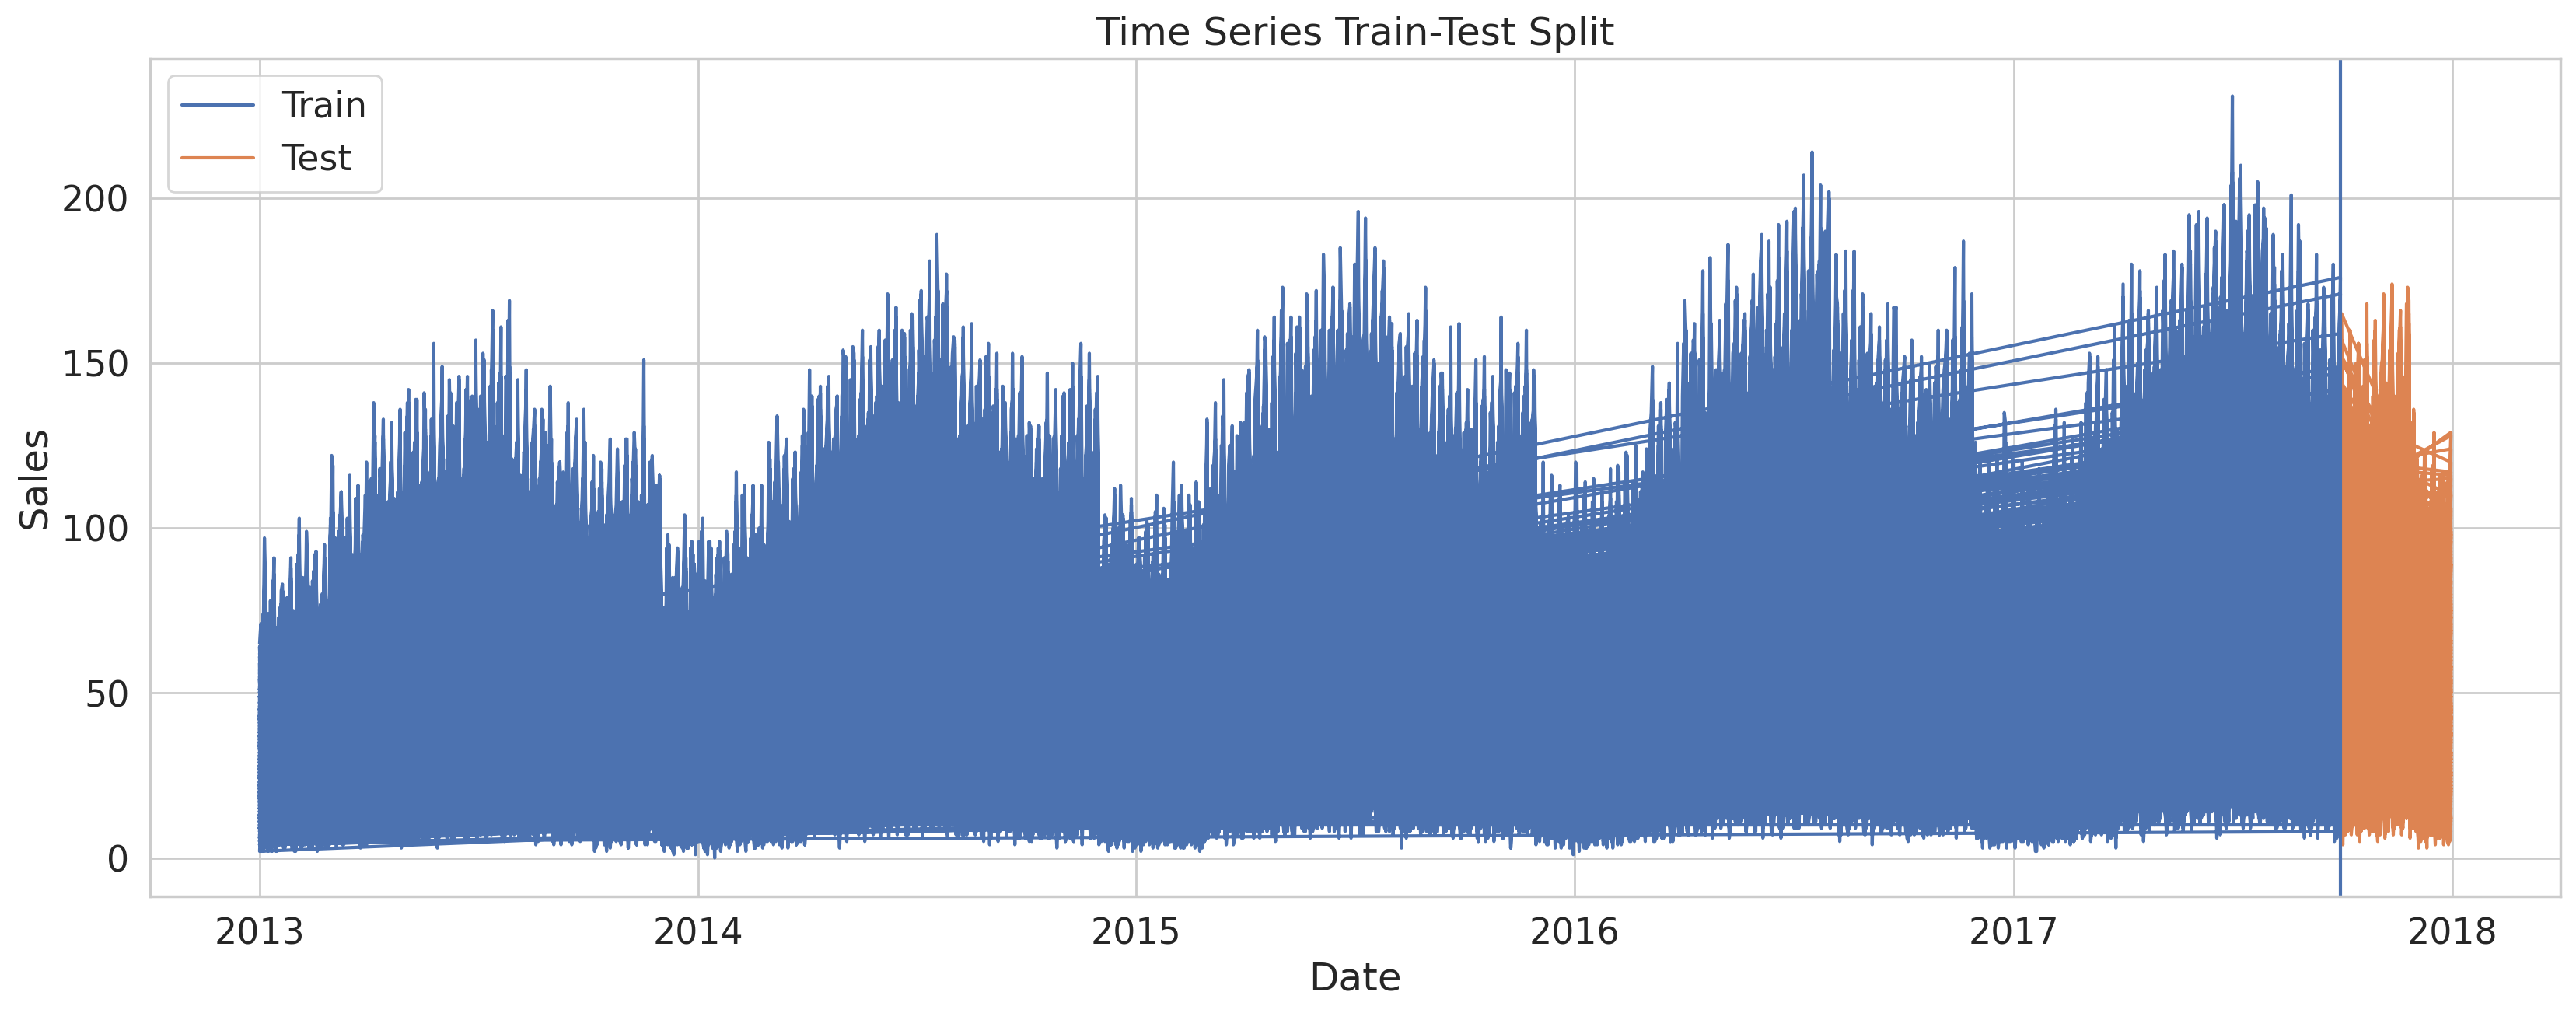

In [ ]:
    plt.figure(figsize=(20, 7))
    plt.plot(train.index, train['sales'], label='Train')
    plt.plot(test.index, test['sales'], label='Test')
    plt.axvline(pd.to_datetime(CUTOFF_DATE))
    plt.title('Time Series Train-Test Split')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [ ]:
print(f"There are {train['store'].nunique()} stores and {train['item'].nunique()} departments.")

There are 10 stores and 50 departments.


In [ ]:
train.groupby(['store'])['item'].nunique()

,item
store,
1,50
2,50
3,50
4,50
5,50
6,50
7,50
8,50
9,50


In [ ]:
Store_Sales= train.groupby(['store']).agg({'sales': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})

In [ ]:
for col in Store_Sales['sales'].columns:
    print(f"Top 3 stores for {col}:")
    print(Store_Sales['sales'][col].nlargest(3))
    print()


Top 3 stores for count:
store
1    86700
2    86700
3    86700
Name: count, dtype: int64

Top 3 stores for sum:
store
2    5796937
8    5546470
3    5148794
Name: sum, dtype: int64

Top 3 stores for mean:
store
2    66.862018
8    63.973126
3    59.386321
Name: mean, dtype: float64

Top 3 stores for median:
store
2    62.0
8    59.0
3    55.0
Name: median, dtype: float64

Top 3 stores for std:
store
2    33.625848
8    32.254070
3    30.002082
Name: std, dtype: float64

Top 3 stores for min:
store
4    4
8    4
9    4
Name: min, dtype: int64

Top 3 stores for max:
store
2    231
8    204
3    196
Name: max, dtype: int64



In [ ]:
Item_Sales= train.groupby(['item']).agg({'sales': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})
Item_Sales.head()

sales                                               
      count      sum       mean median        std min  max
item                                                      
1     17340   380279  21.930738   21.0   8.493474   1   59
2     17340  1013372  58.441292   56.0  20.196348   9  150
3     17340   633580  36.538639   35.0  13.216976   7  104
4     17340   380775  21.959343   21.0   8.433742   0   66
5     17340   317458  18.307843   18.0   7.284940   1   50

In [ ]:
for col in Item_Sales['sales'].columns:
    print(f"Top 3 items for {col}:")
    print(Item_Sales['sales'][col].nlargest(3))
    print()

Top 3 items for count:
item
1    17340
2    17340
3    17340
Name: count, dtype: int64

Top 3 items for sum:
item
15    1522523
28    1519951
13    1458659
Name: sum, dtype: int64

Top 3 items for mean:
item
15    87.804095
28    87.655767
13    84.121050
Name: mean, dtype: float64

Top 3 items for median:
item
15    84.0
28    84.0
13    81.0
Name: median, dtype: float64

Top 3 items for std:
item
15    29.636305
28    29.614129
18    28.550043
Name: std, dtype: float64

Top 3 items for min:
item
13    20
18    18
25    18
Name: min, dtype: int64

Top 3 items for max:
item
15    231
22    214
13    210
Name: max, dtype: int64



<Figure size 640x480 with 0 Axes>

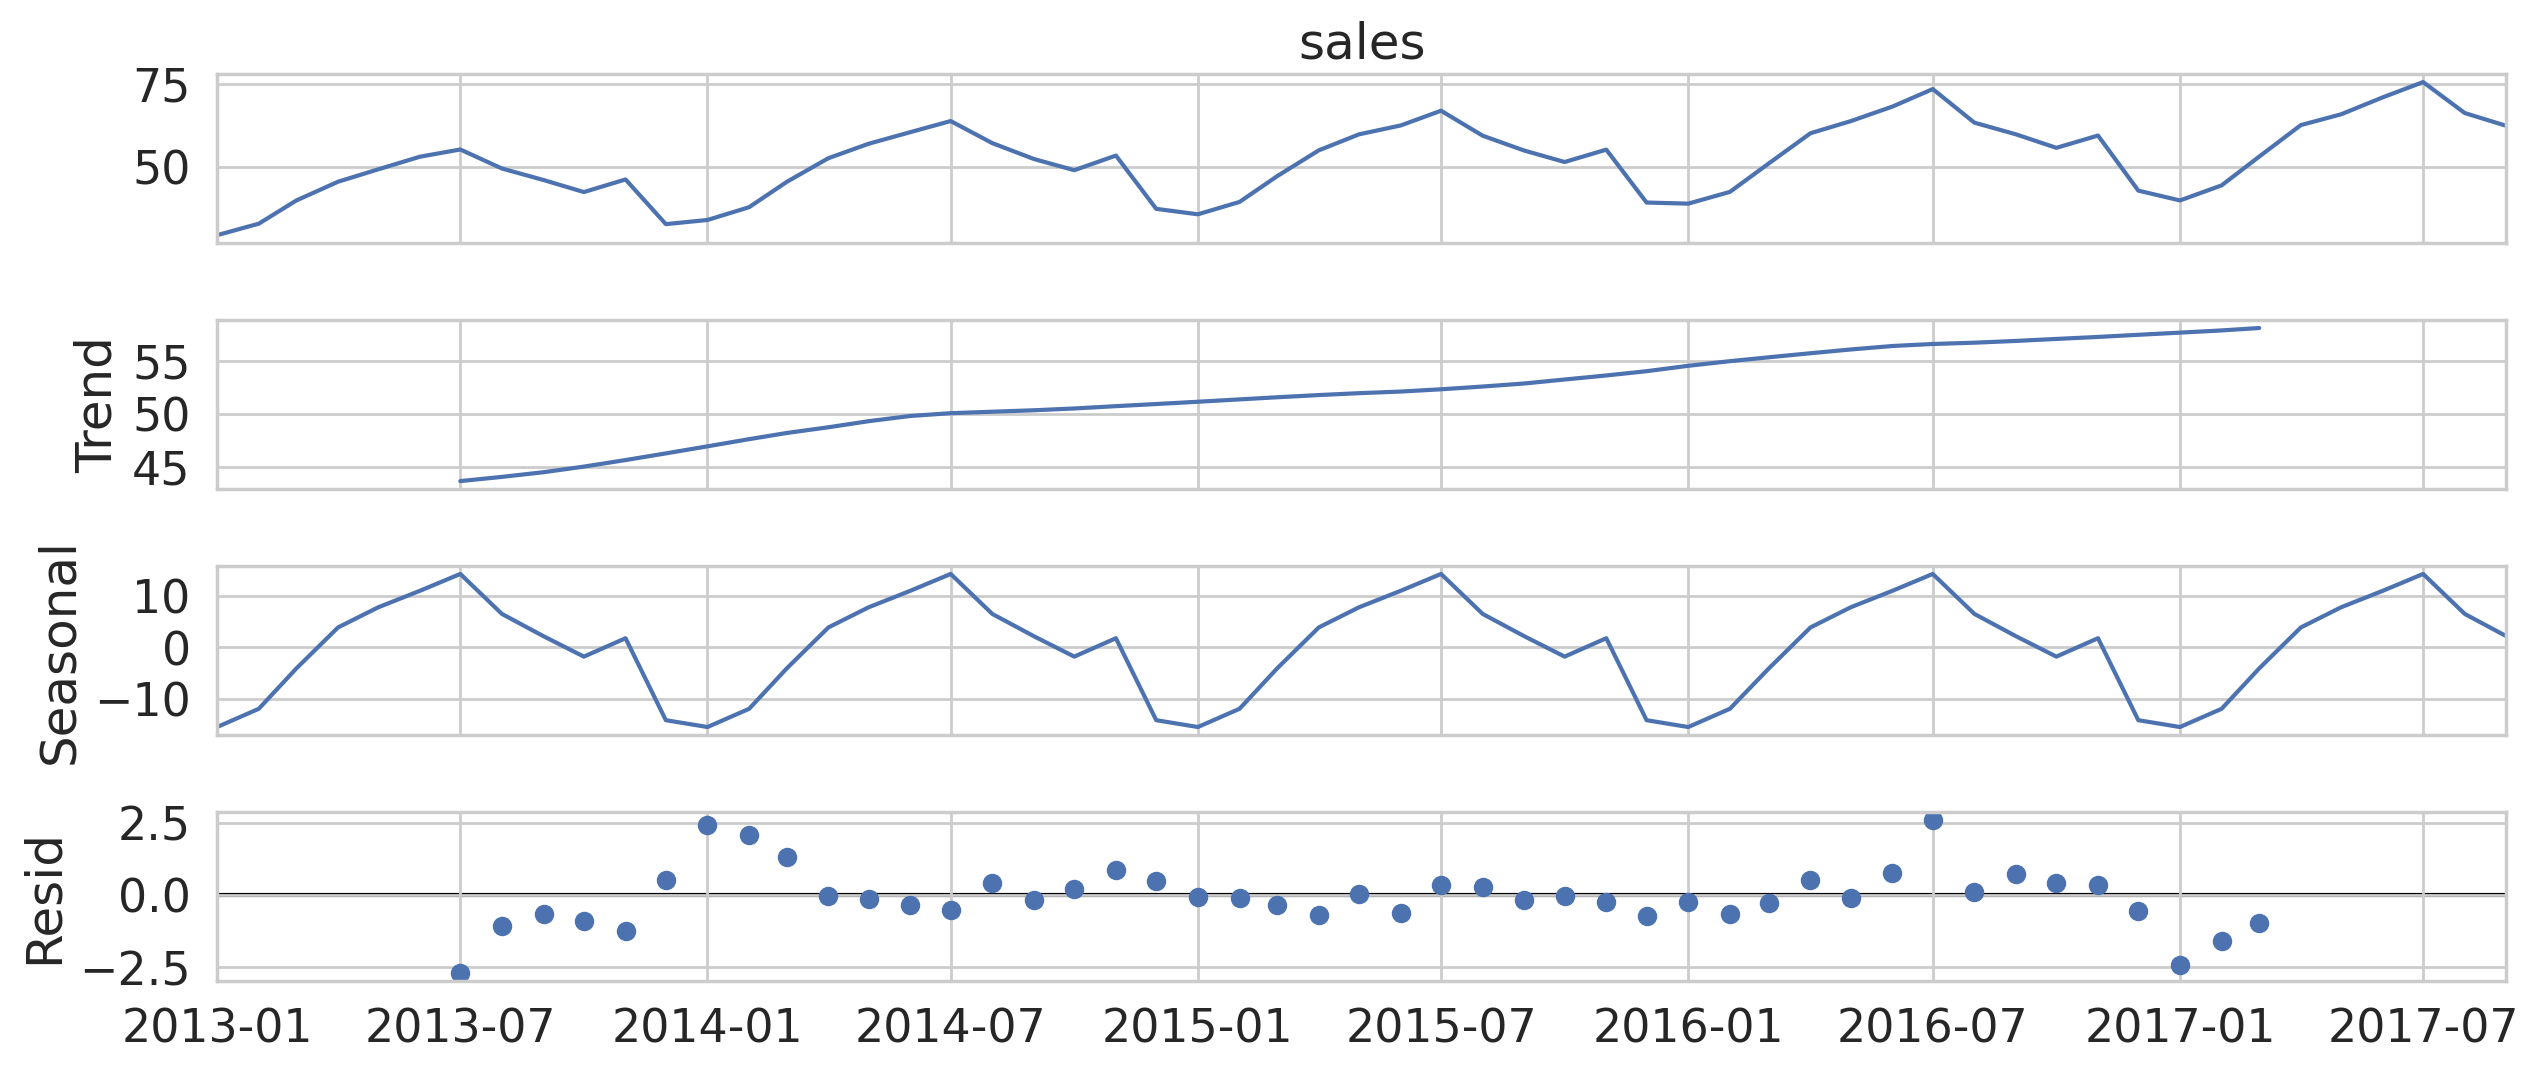

In [ ]:
monthly_avg_sales = train['sales'].resample('MS').mean()
ts_decomposition = sm.tsa.seasonal_decompose(monthly_avg_sales, model='additive')

fig = plt.figure()
fig = ts_decomposition.plot()
fig.set_size_inches(16, 6)

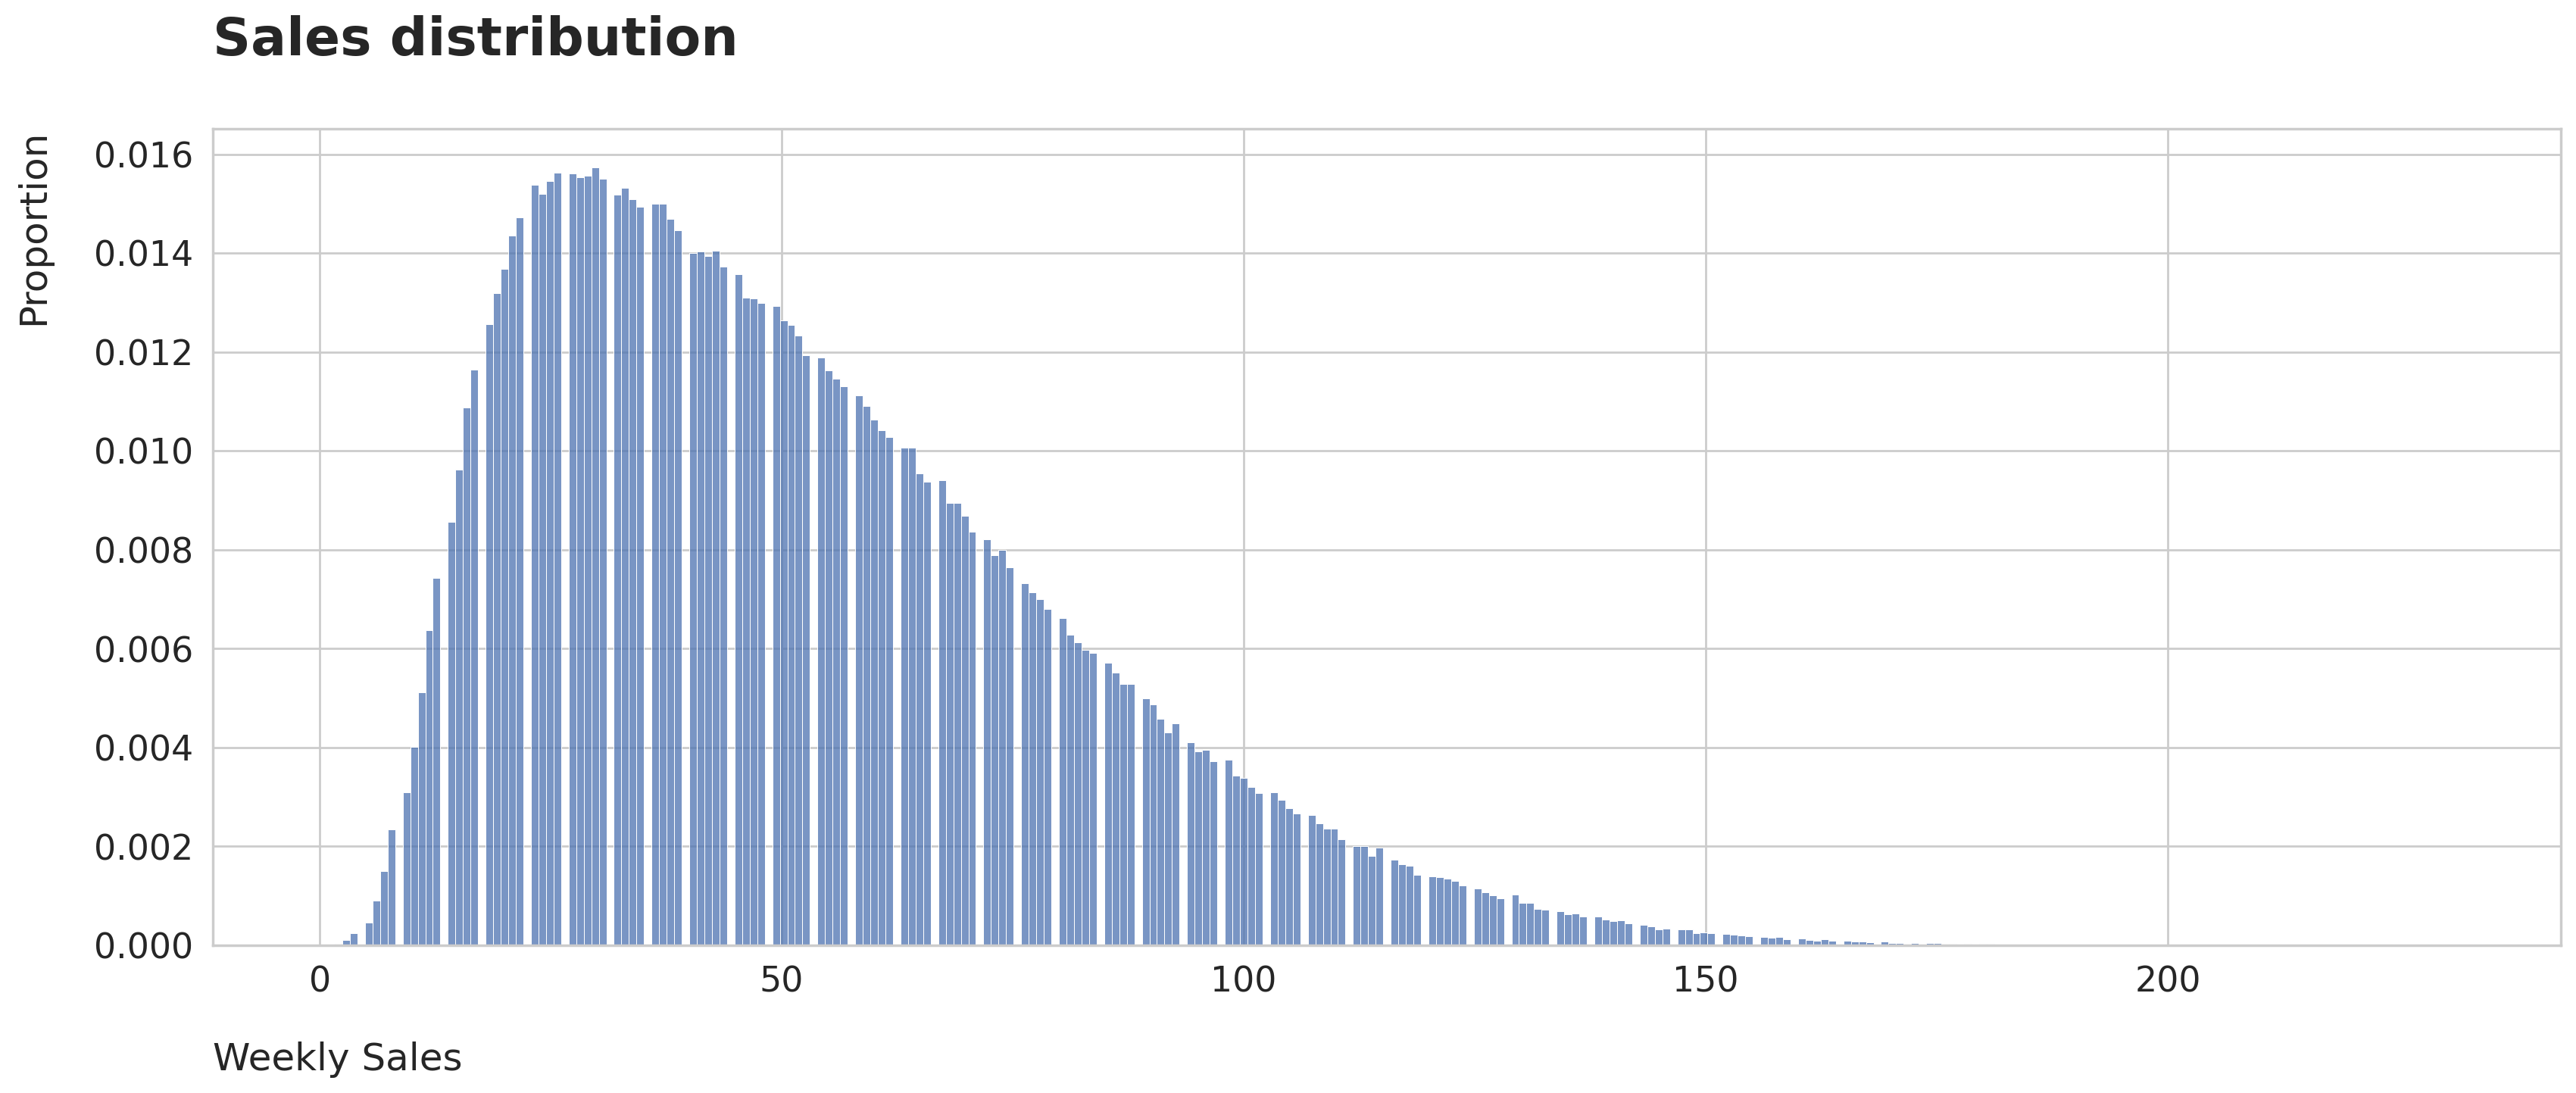

In [ ]:
plt.figure(figsize=(20, 7))
sns.histplot(data=train, x='sales', stat='proportion')
plt.title('Sales distribution', loc='left', pad=35, fontsize=25, fontweight='bold')
plt.xlabel('Weekly Sales', loc='left', labelpad=20)
plt.ylabel('Proportion', loc='top', labelpad=20)
plt.show()

In [ ]:
train['sales'].agg(['skew', 'kurtosis'])

,sales
skew,0.875691
kurtosis,0.535870


### Sales over the time

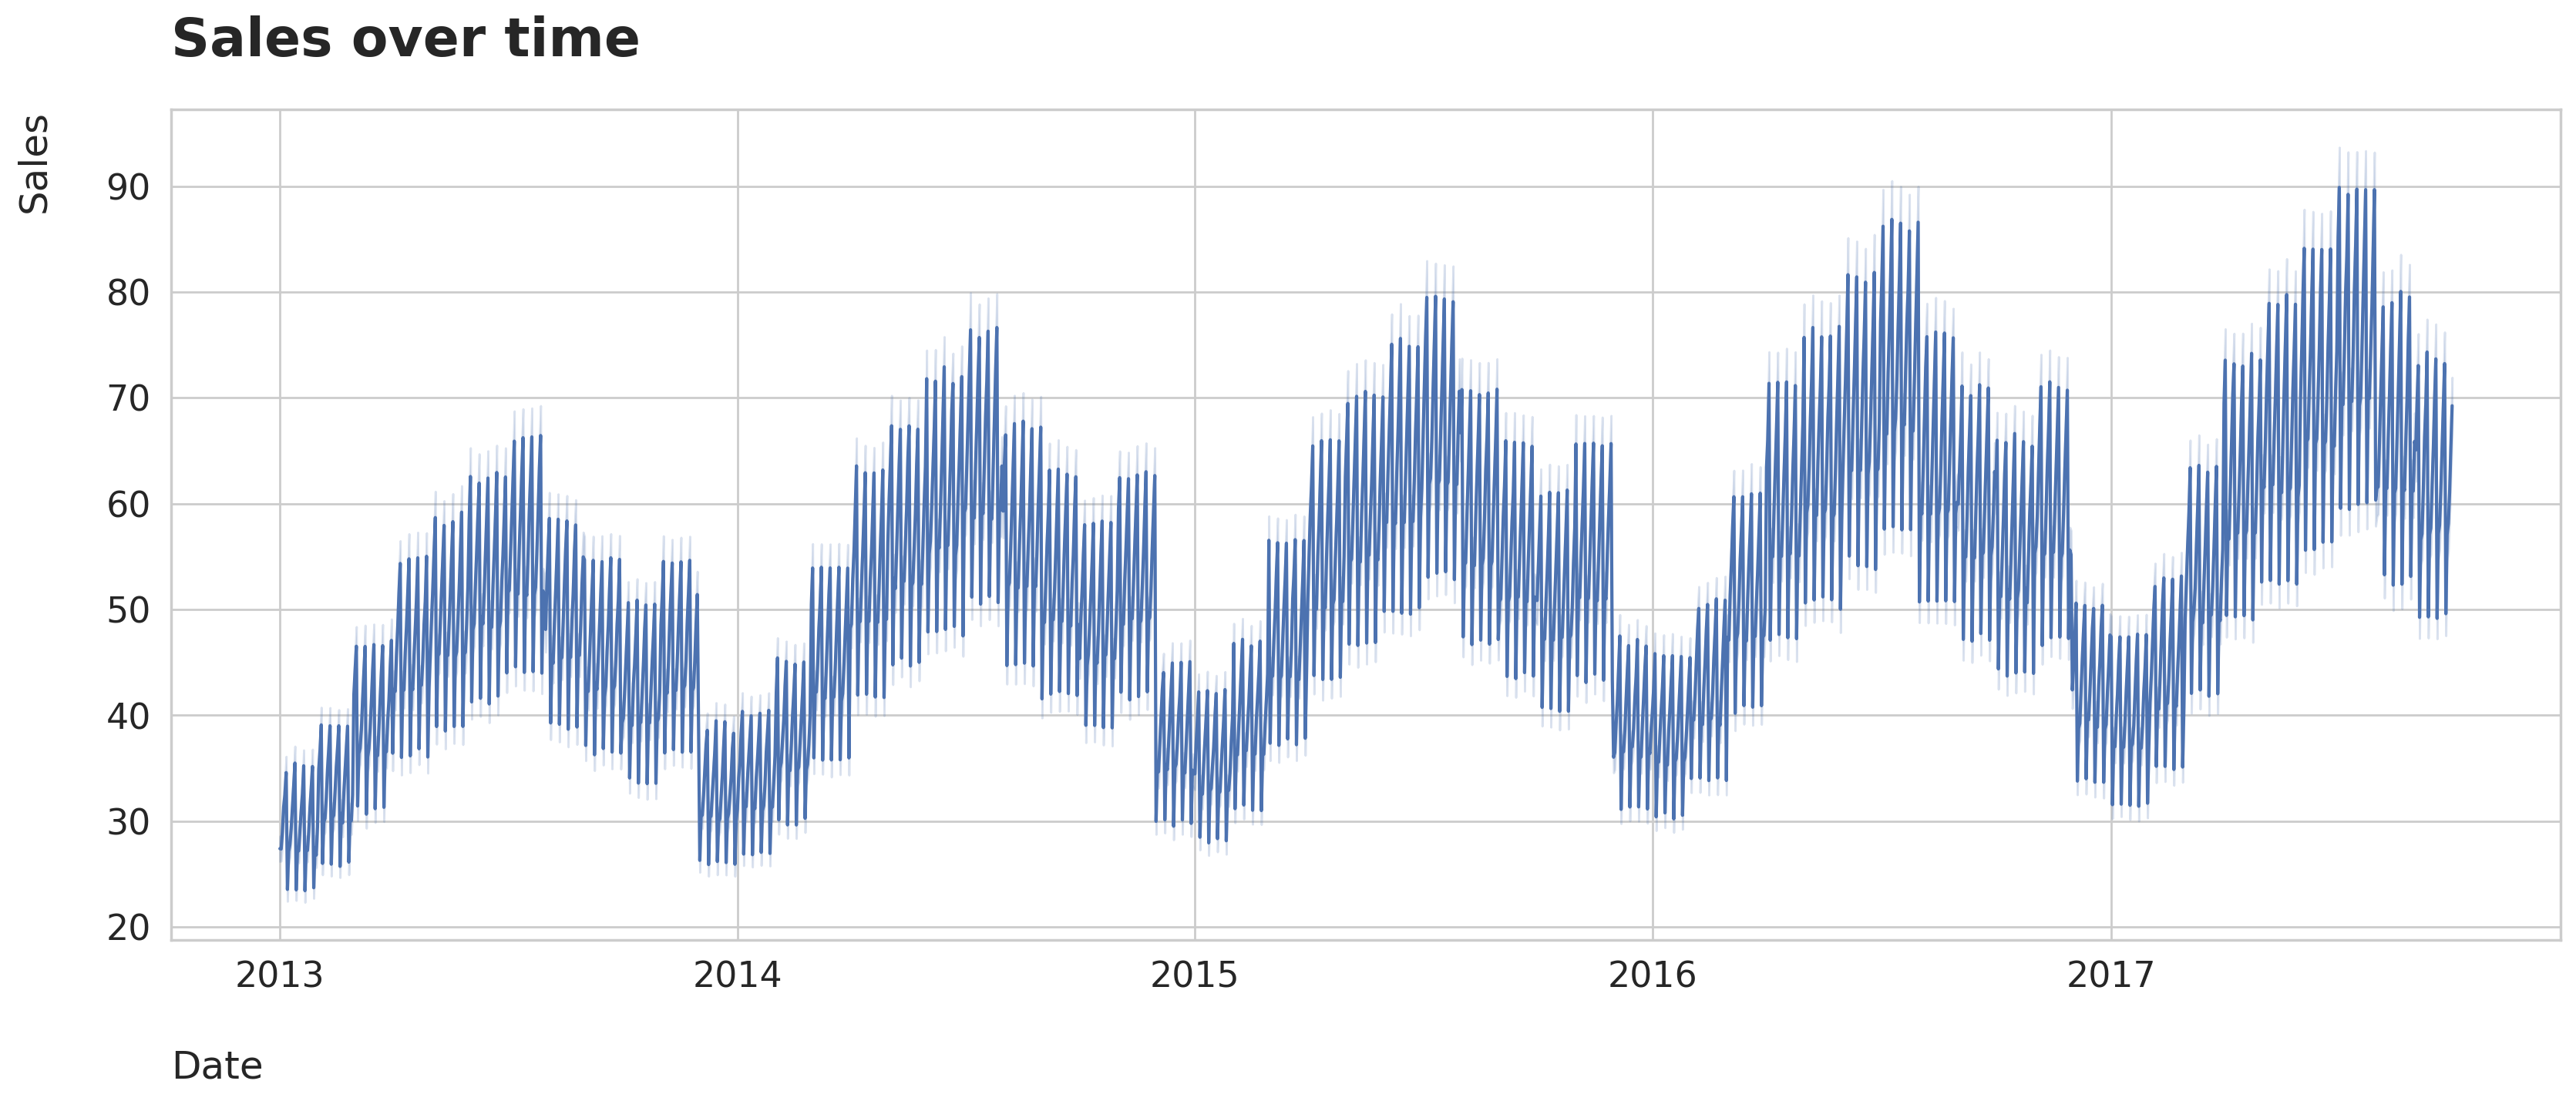

In [ ]:
plt.figure(figsize=(20, 7))
plt.title('Sales over time', loc='left', fontsize=25, fontweight='bold', pad=25)
sns.lineplot(data=train, x='date', y='sales')
plt.xlabel('Date', loc='left', labelpad=25)
plt.ylabel('Sales', loc='top', labelpad=25)
plt.show()

###Sales over the months per year

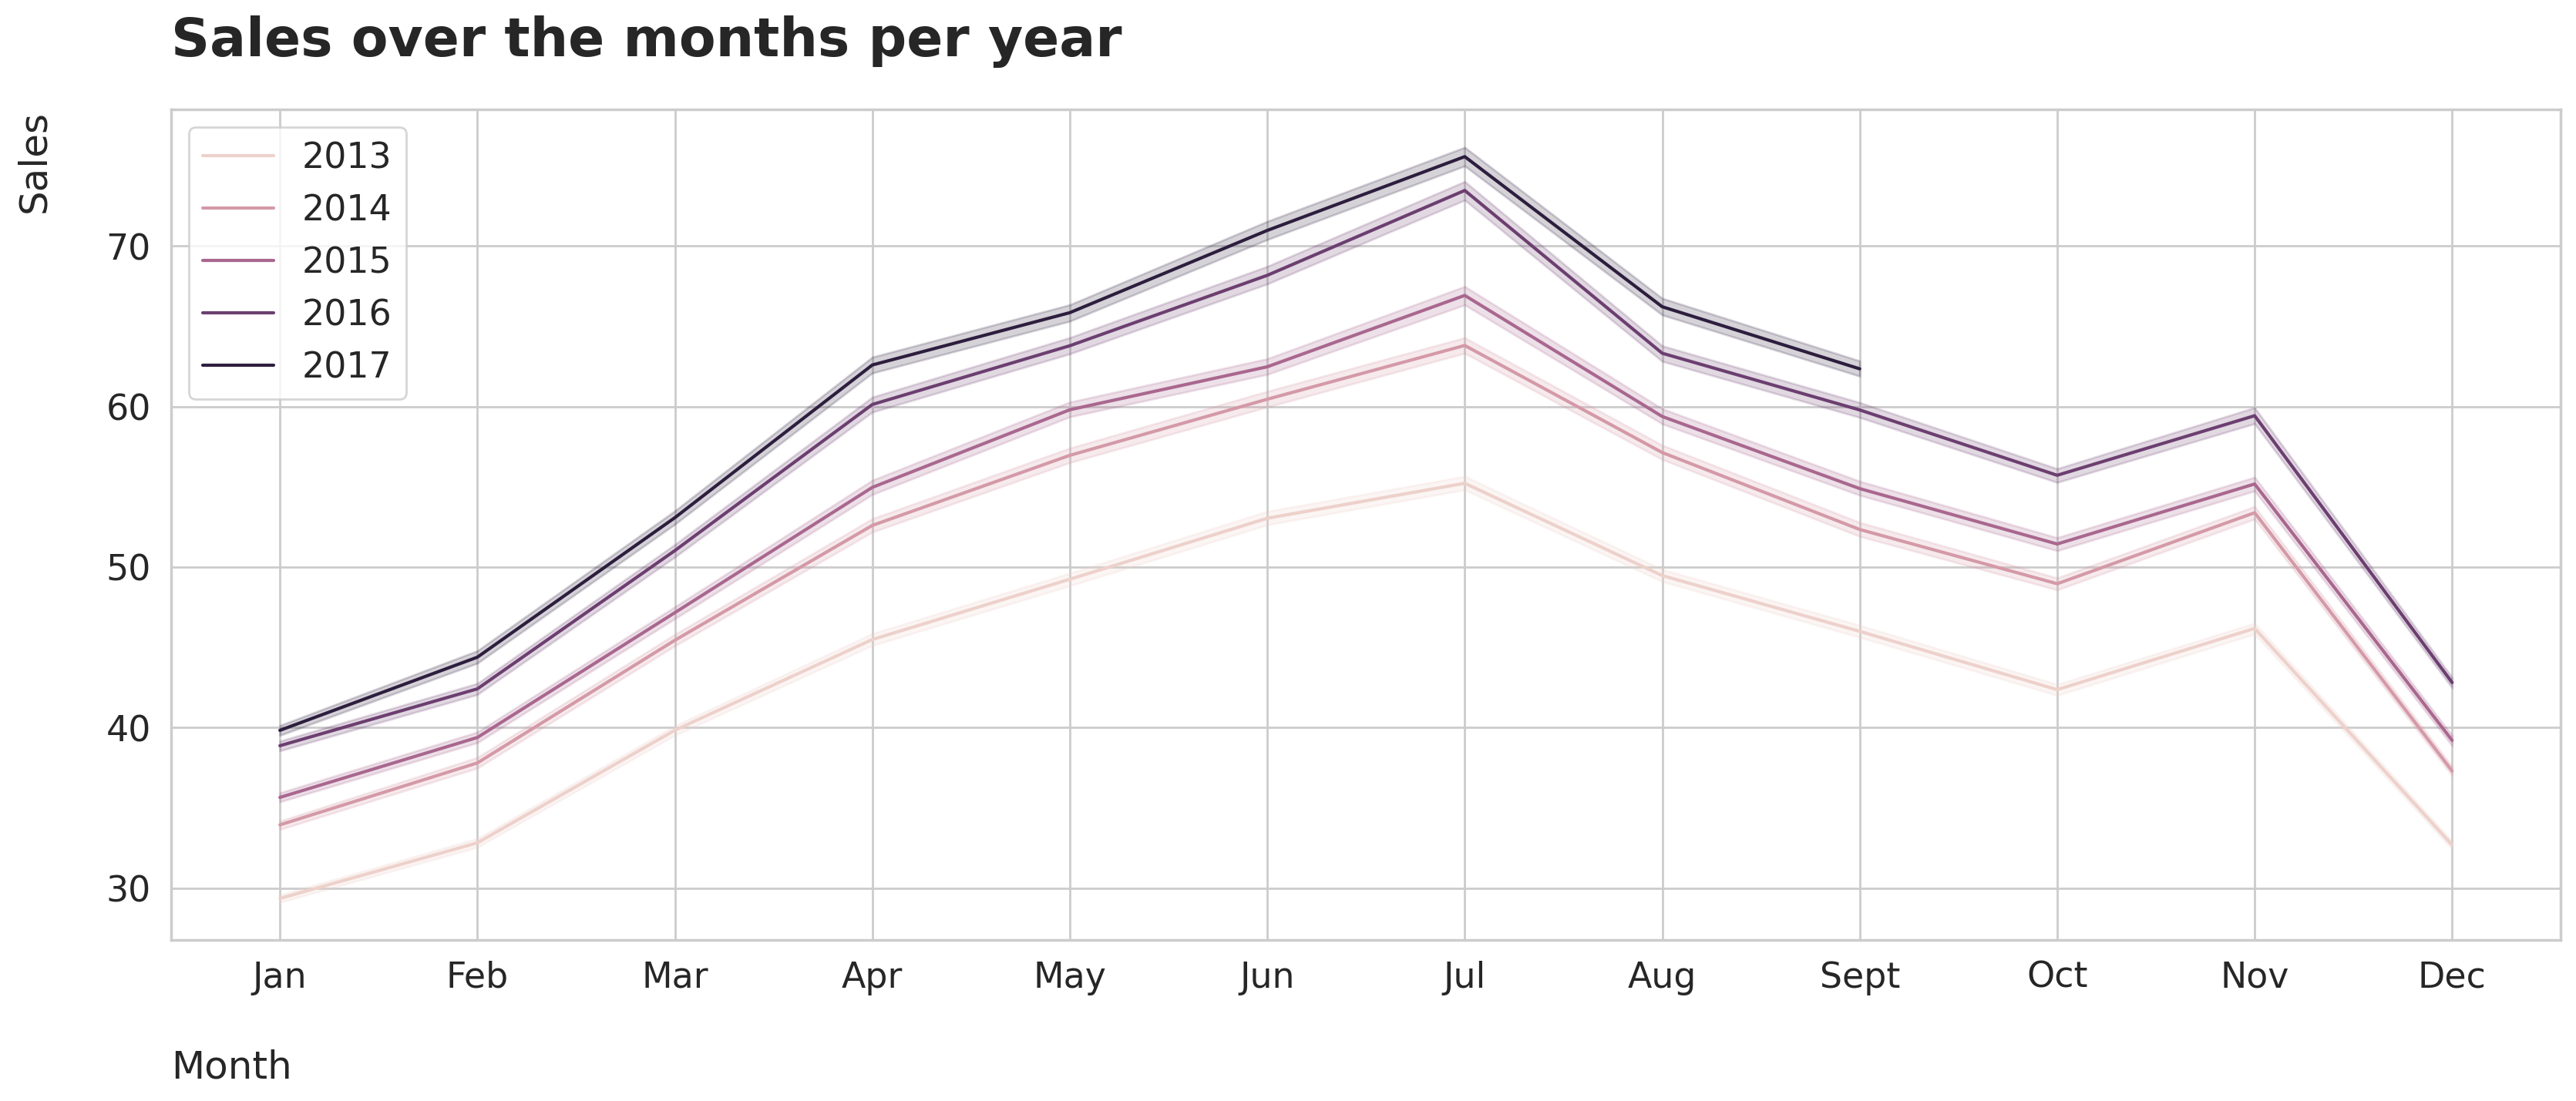

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=train, x='month', y='sales', hue='year')
plt.title('Sales over the months per year', fontsize=25, fontweight='bold', loc='left', pad=25)
plt.xlabel('Month', loc='left', labelpad=25)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Sales', loc='top', labelpad=25)
plt.legend(loc='upper left')
plt.show()

###Sales over the weeks of year

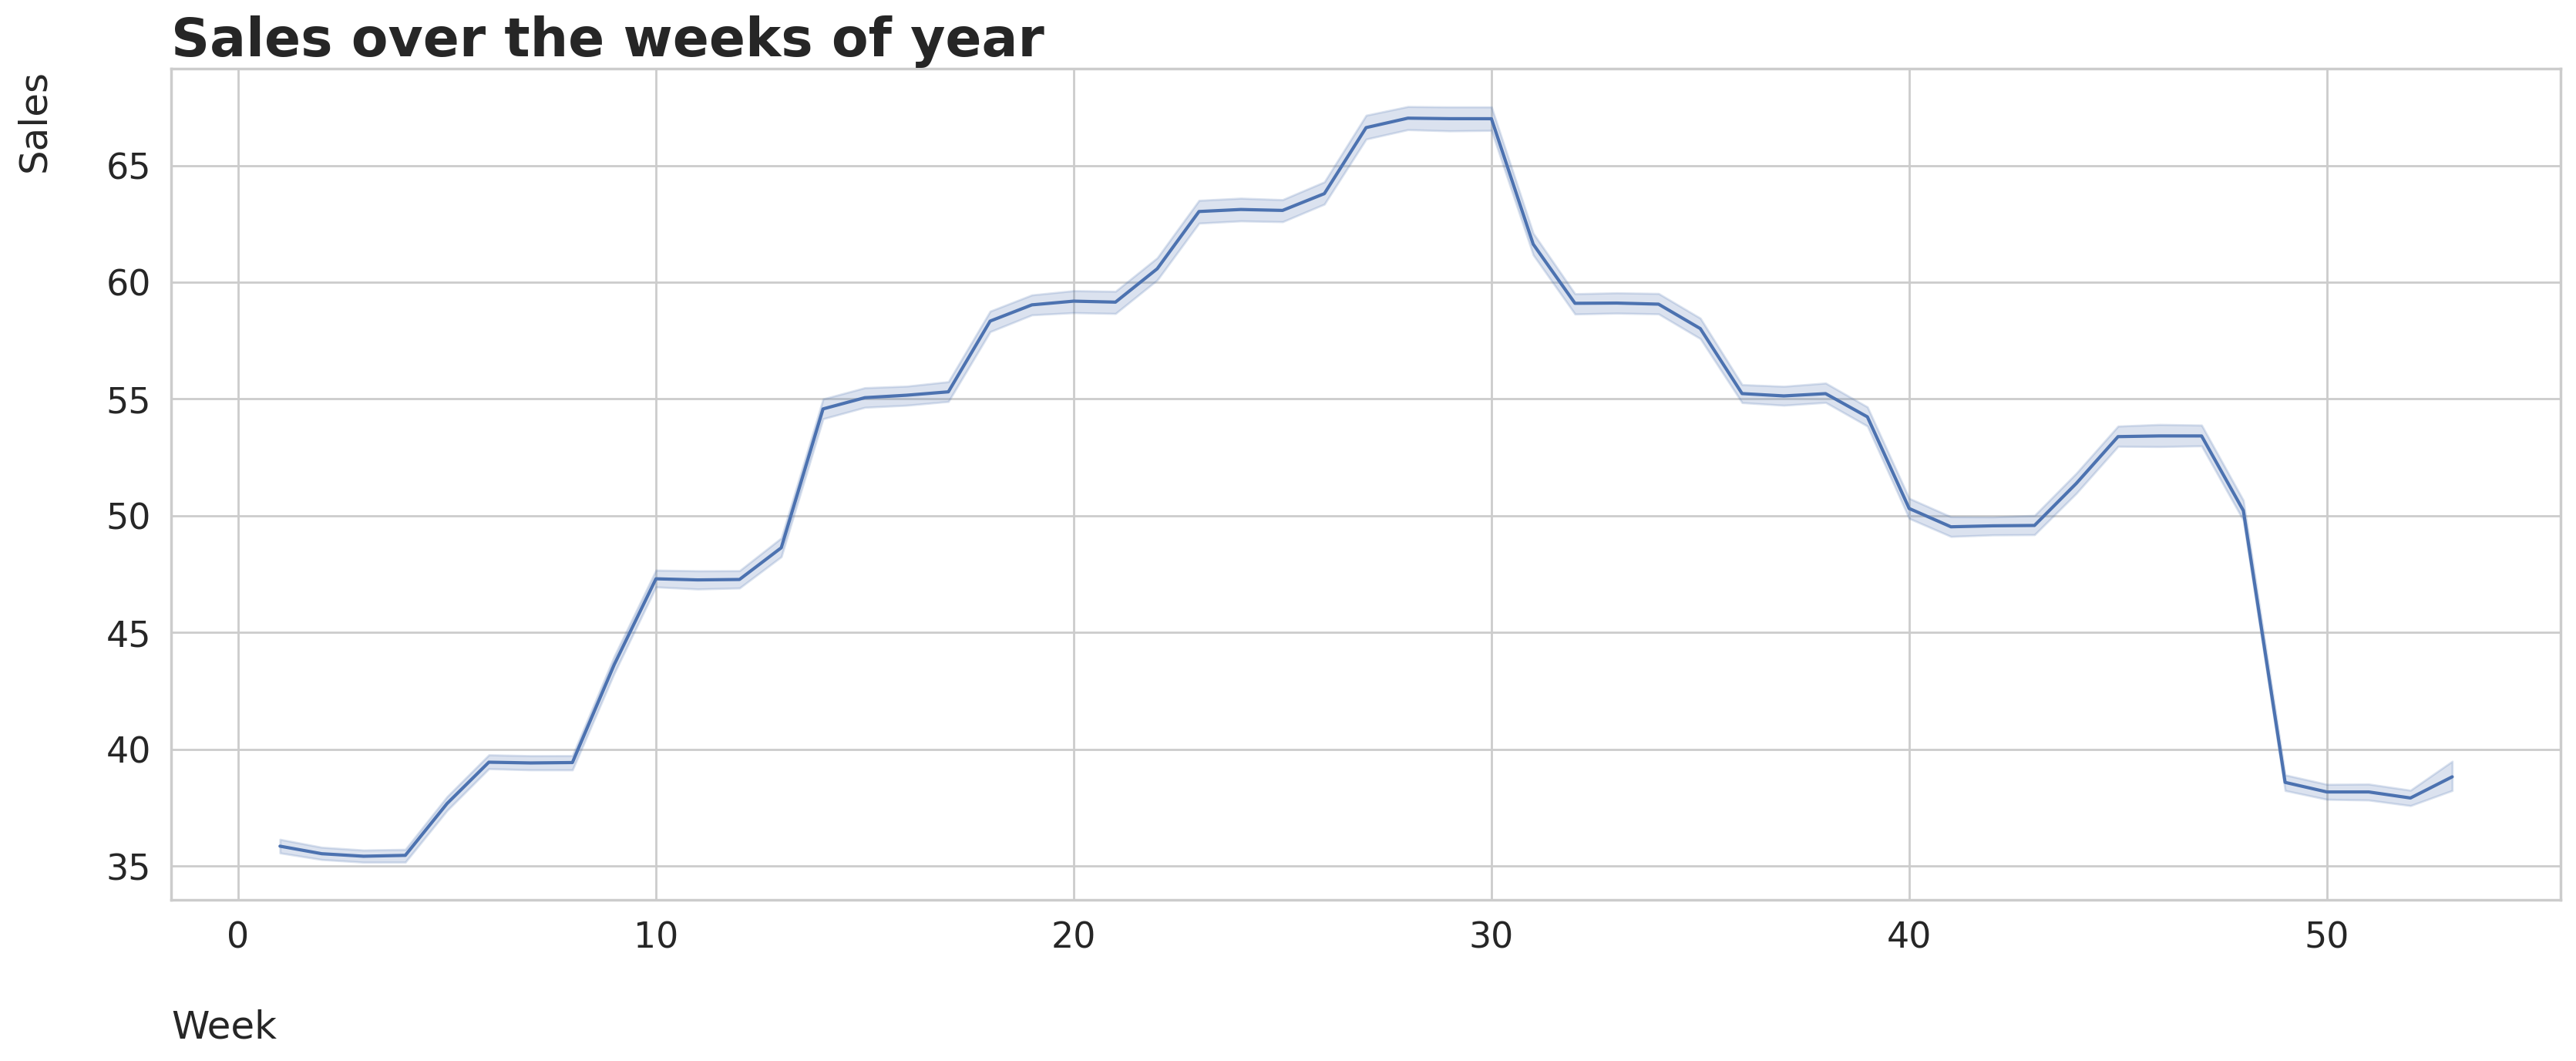

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=train, x='week_of_year', y='sales')
plt.title('Sales over the weeks of year', fontsize=25, fontweight='bold', loc='left')
plt.xlabel('Week', loc='left', labelpad=25)
plt.ylabel('Sales', loc='top', labelpad=25)
plt.show()

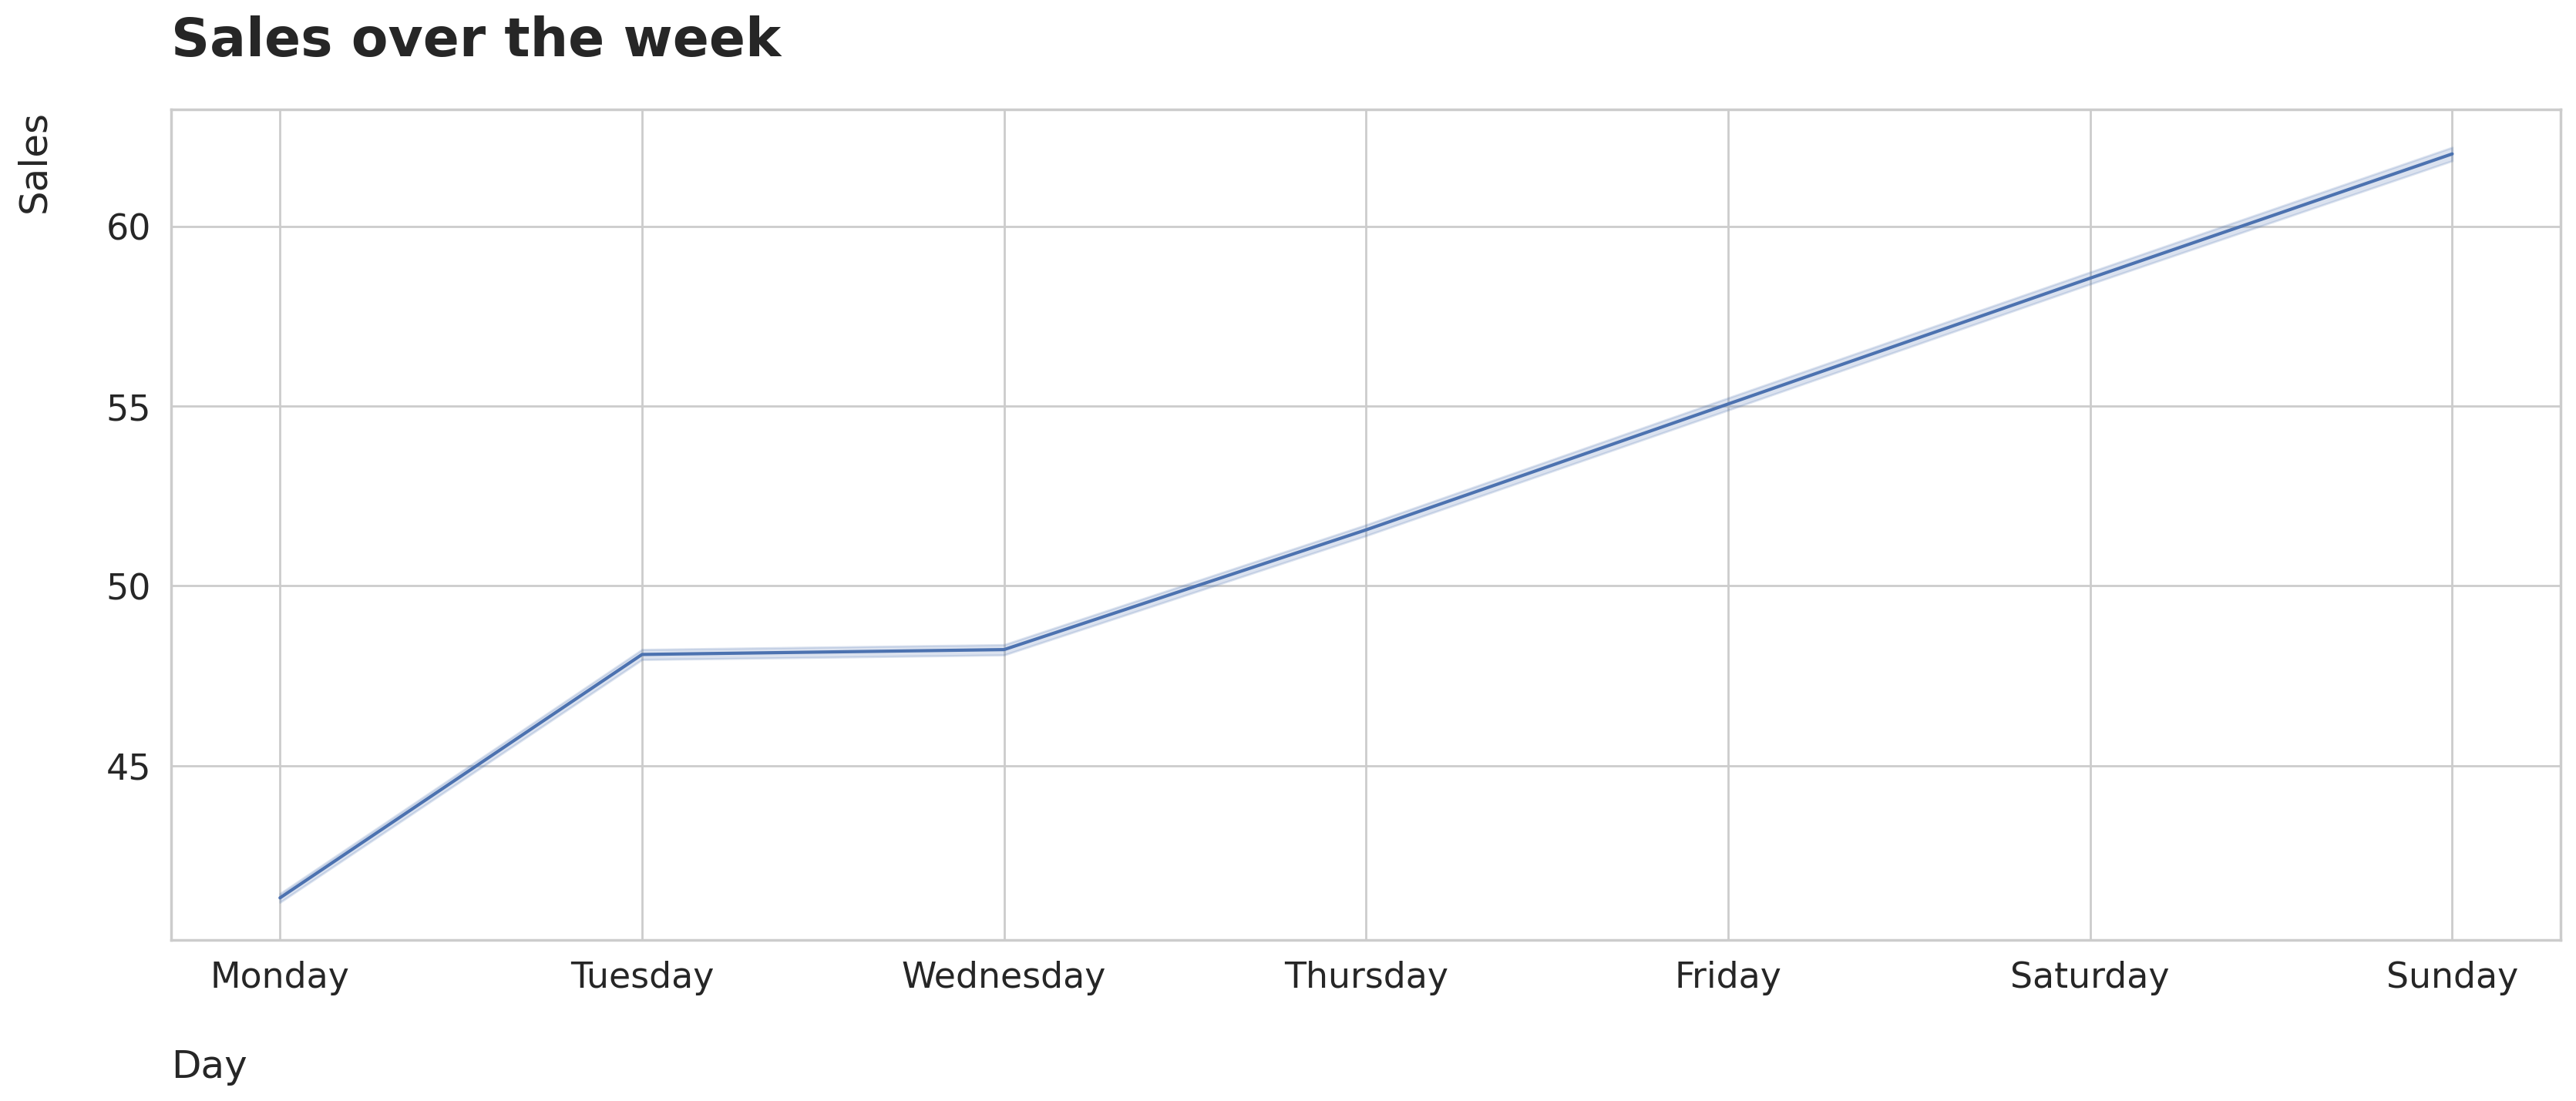

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=train, x='day_of_week', y='sales')
plt.title('Sales over the week', fontsize=25, fontweight='bold', loc='left', pad=25)
plt.xlabel('Day', loc='left', labelpad=25)
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel('Sales', loc='top', labelpad=25)
plt.show()

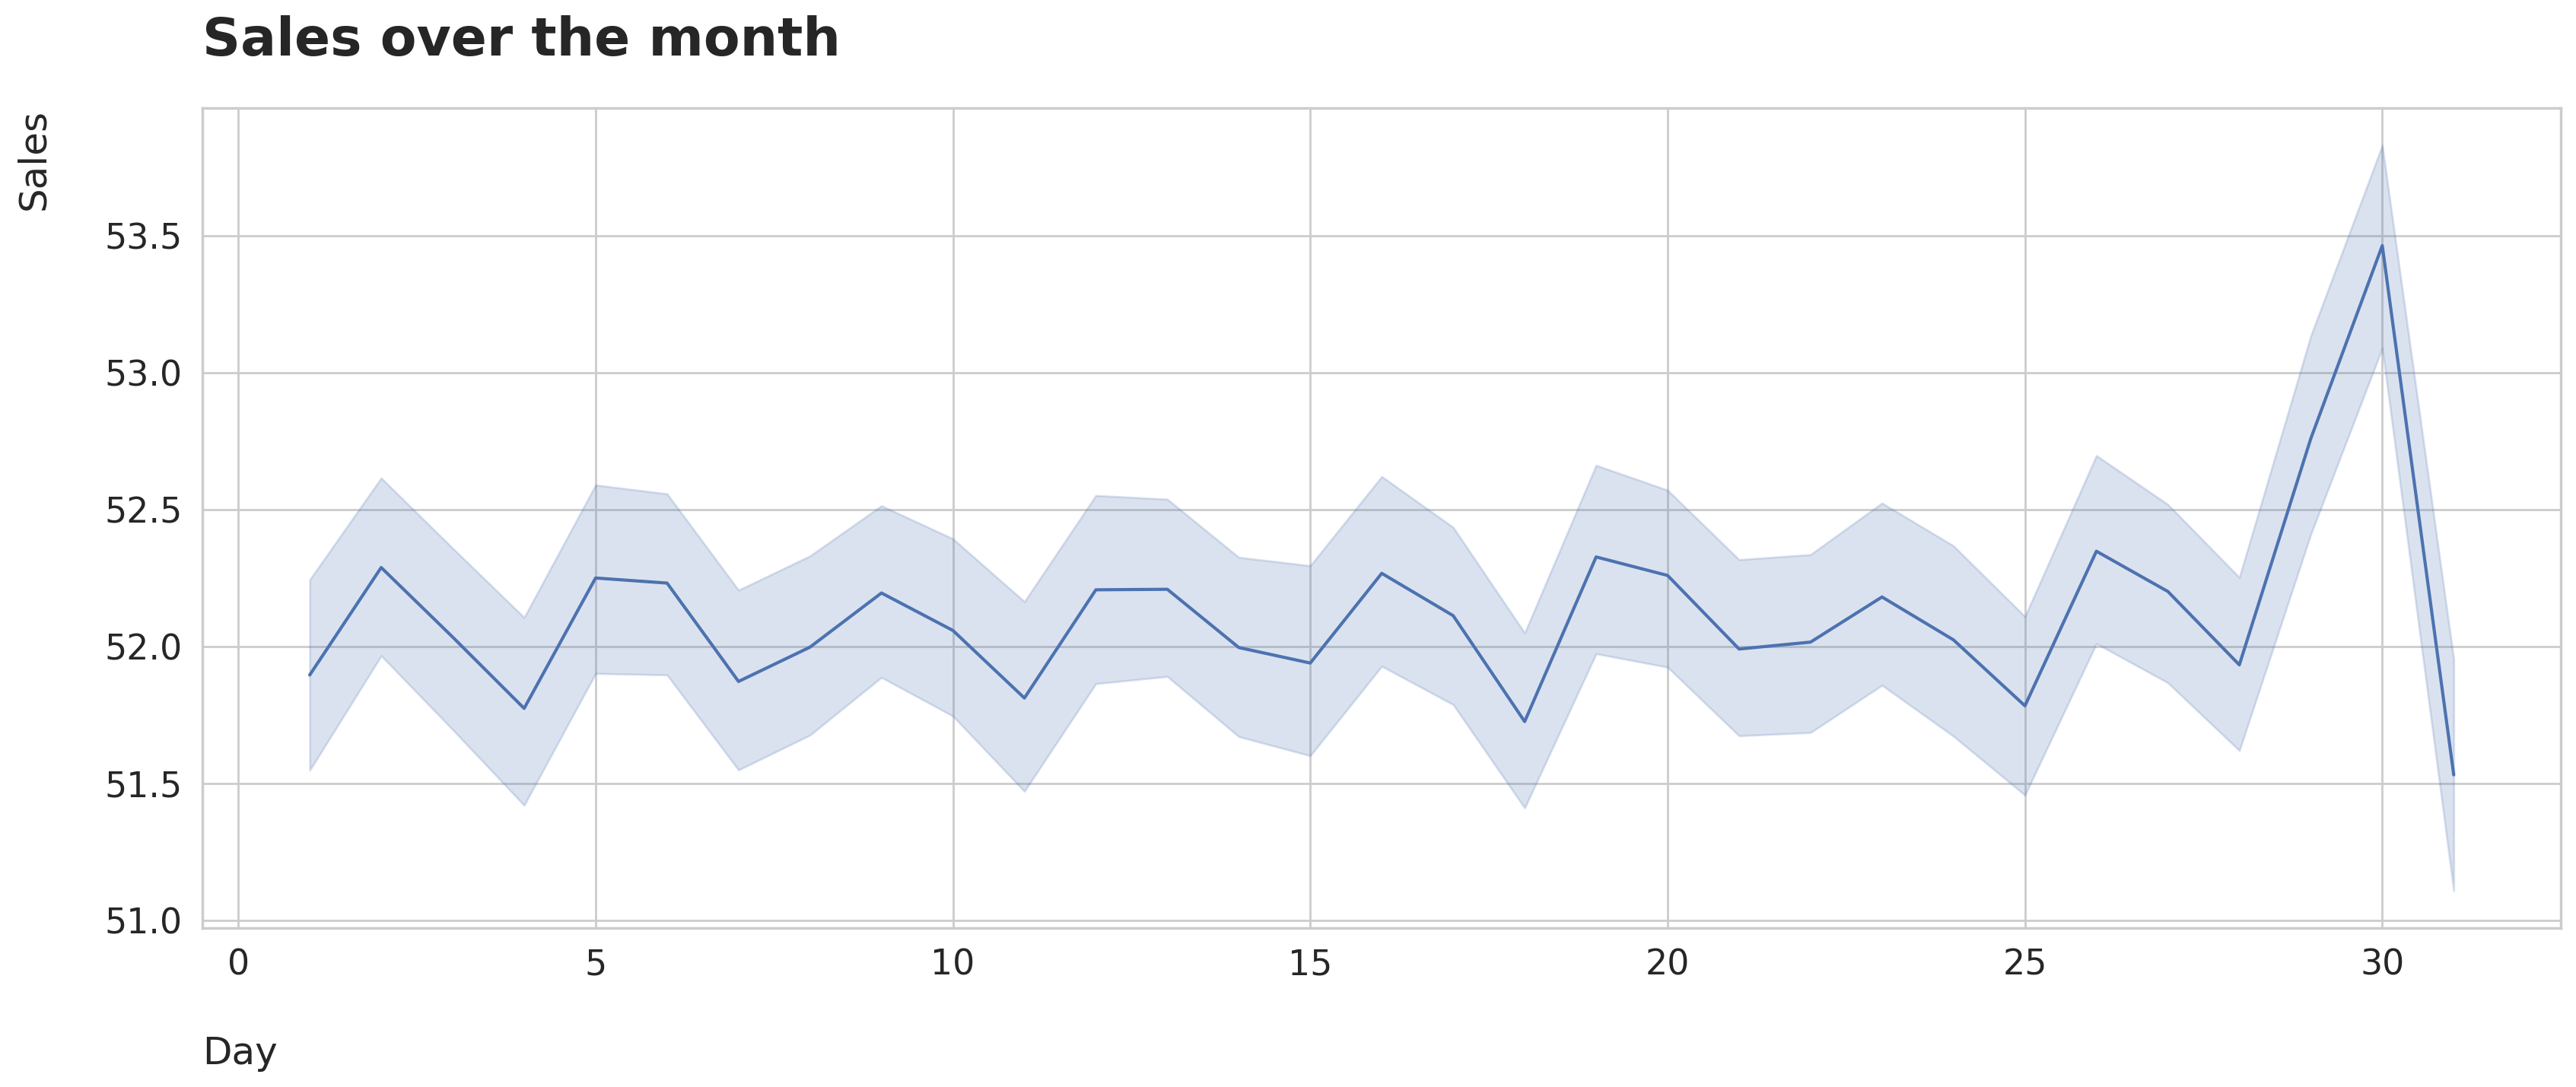

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=train, x='day_of_month', y='sales')
plt.title('Sales over the month', fontsize=25, fontweight='bold', loc='left', pad=25)
plt.xlabel('Day', loc='left', labelpad=25)
plt.ylabel('Sales', loc='top', labelpad=25)
plt.show()

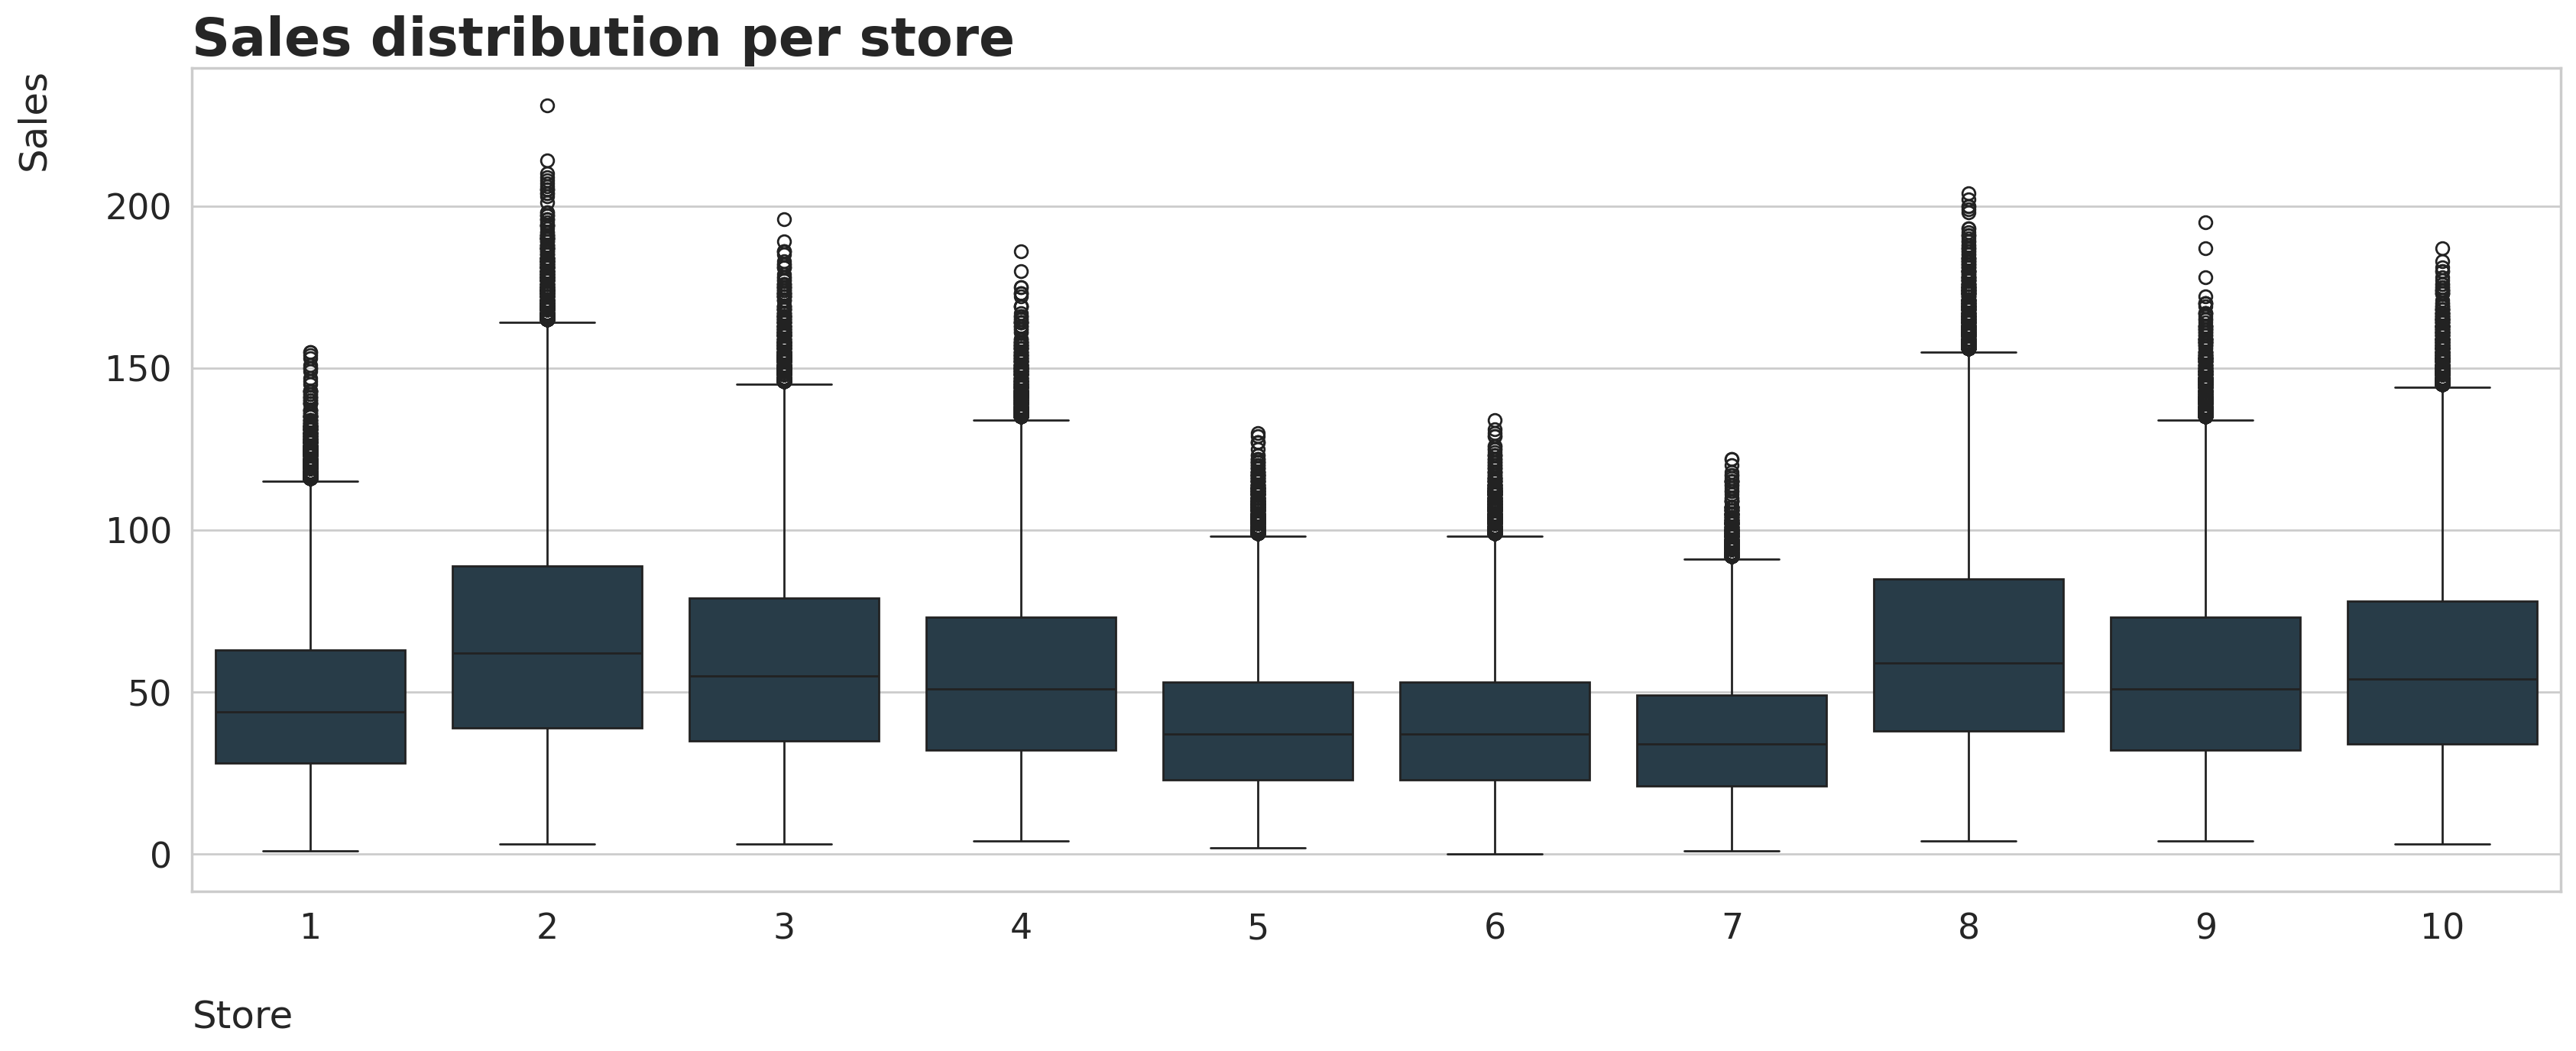

In [ ]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=train, x='store', y='sales', color='#233D4D')
plt.title('Sales distribution per store', fontsize=25, fontweight='bold', loc='left')
plt.xlabel('Store', labelpad=25, loc='left')
plt.ylabel('Sales', labelpad=25, loc='top')
plt.show()

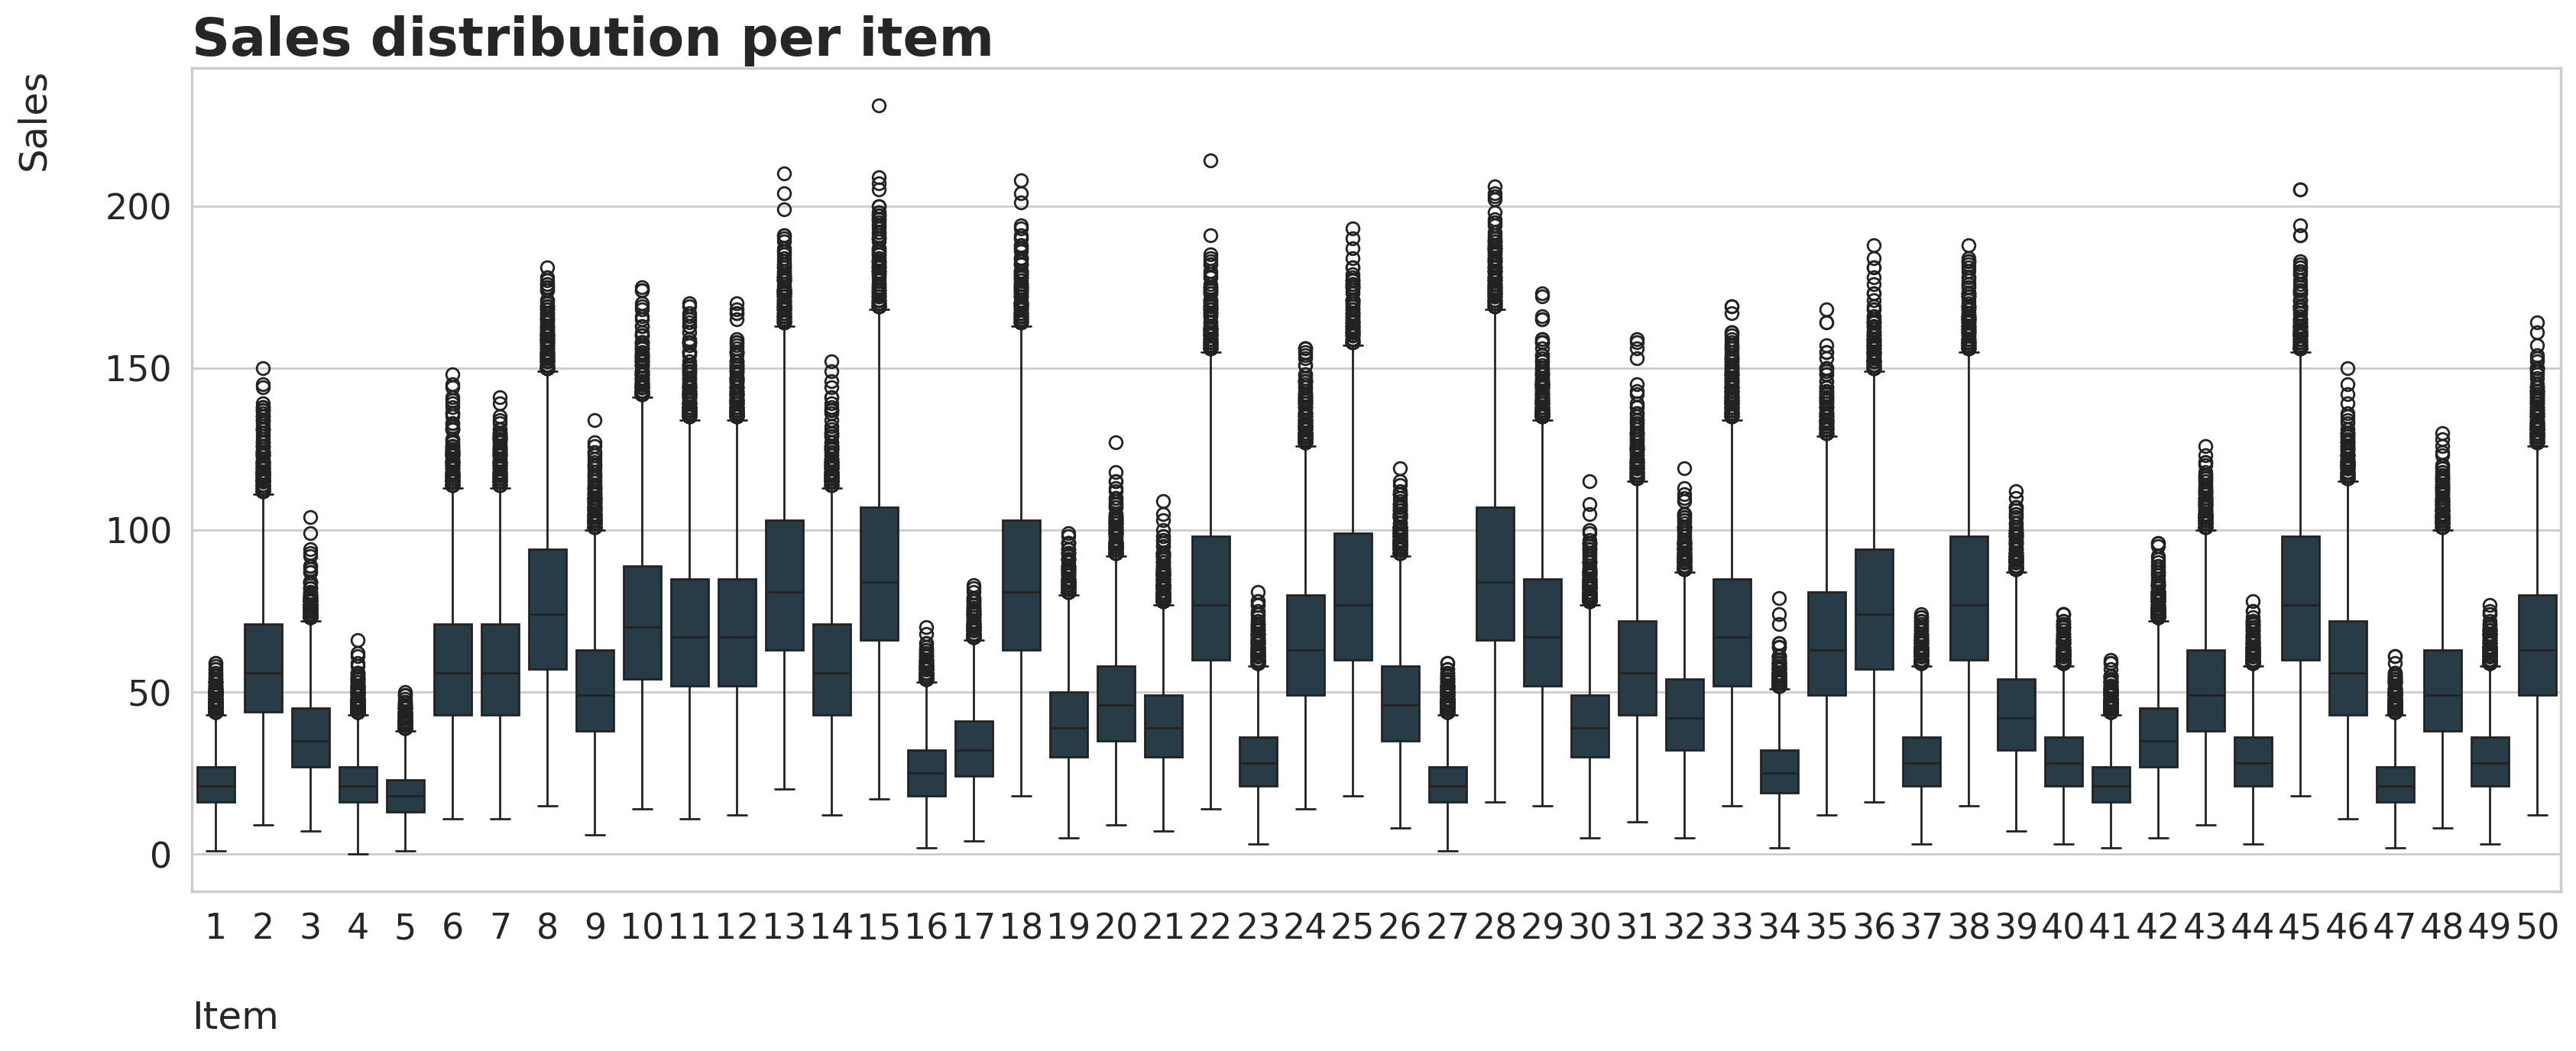

In [ ]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=train, x='item', y='sales', color='#233D4D')
plt.title('Sales distribution per item', fontsize=25, fontweight='bold', loc='left')
plt.xlabel('Item', labelpad=25, loc='left')
plt.ylabel('Sales', labelpad=25, loc='top')
plt.show()

###Outlier Analysis

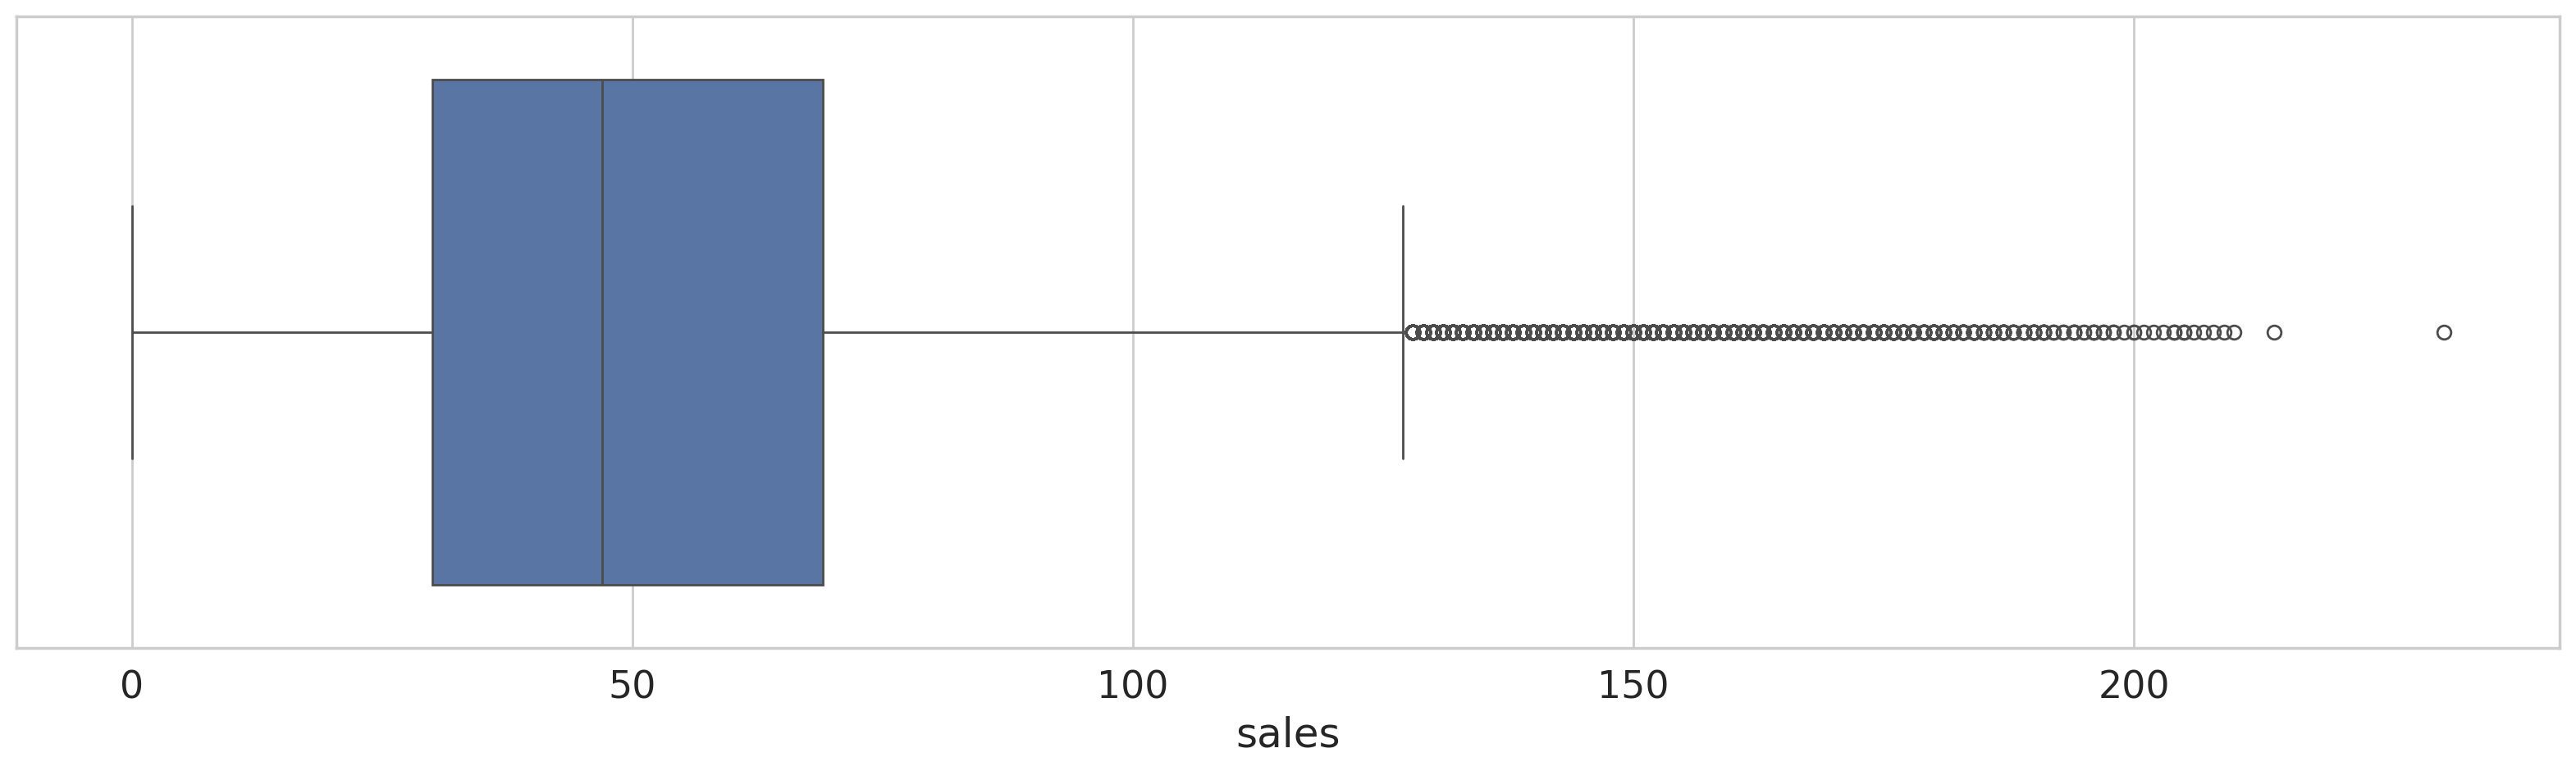

In [ ]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=train, x='sales')
plt.show()

In [ ]:
train.loc[train['sales'] > 200, ['sales', 'store', 'day_of_week', 'month']]

,sales,store,day_of_week,month
date,,,,
2016-07-24,204,2,6,7
2017-07-09,210,2,6,7
2016-07-10,207,2,6,7
2016-07-17,209,2,6,7
2017-07-02,231,2,6,7
2017-07-09,205,2,6,7
2017-07-02,208,2,6,7
2017-07-08,204,2,5,7
2017-08-20,201,2,6,8


In [ ]:
train.loc[train['sales'] == train['sales'].max(), ['sales', 'store', 'day_of_week', 'month']]

,sales,store,day_of_week,month
date,,,,
2017-07-02,231,2,6,7


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [ ]:
train.loc[:, 'sales_lag_7'] = train['sales'].shift(7)
train.loc[:, 'sales_rolling_mean_7'] = train['sales'].rolling(window=7).mean()

train = train.dropna()

In [ ]:
features = ['store', 'item', 'year', 'month', 'day_of_week', 'day_of_month', 'week_of_year', 'quarter', 'is_wknd', 'is_month_start', 'is_month_end', 'sales_lag_7', 'sales_rolling_mean_7']
target = 'sales'

X_train = train[features]
y_train = train[target]

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 866986, number of used features: 13
[LightGBM] [Info] Start training from score 52.122173


LGBMRegressor(feature_fraction=0.9, learning_rate=0.05, metric='rmse',
              objective='regression')

In [ ]:
test['sales_lag_7'] = test['sales'].shift(7)
test['sales_rolling_mean_7'] = test['sales'].rolling(window=7).mean()
test = test.dropna()

X_test = test[features]
y_test = test[target]

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
RMSE: 7.857210080299839
